# 📱 App-Markt Analyse
## Welche Plattform ist attraktiver für App-Entwickler?
**Ziel:** Eine datengetriebene Story mit handlungsrelevantem Outcome
---

## 🔧 Setup & Infrastruktur
- **Datenquellen**: Kaggle CSVs (Google Play, App Store)
- **Speicherung**: MongoDB (NoSQL)
- **Verarbeitung**: Pandas + MapReduce
- **Visualisierung**: Matplotlib / Seaborn
- **Teamarbeit** & Git


# 0️⃣ Datenverarbeitung



## Imports und MongoDB-Verbindung

Zuerst installieren wir erforderliche Bibliotheken und stellen die Verbindung zur MongoDB her.

In [ ]:
# Installiere erforderliche Bibliotheken (falls nicht vorhanden)
!pip install pandas pymongo matplotlib wordcloud

from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

# MongoDB-Verbindung
client = MongoClient("mongodb://localhost:27017/")
db = client['app_market']
raw_coll = db['raw_apps']
clean_coll = db['clean_apps']
mr_coll = db['mr_genre_avg_rating']
print("MongoDB-Verbindung hergestellt.")

## 1. Einlesen des Apple App Store Datensatzes

In [ ]:
# Einlesen des CSV in ein DataFrame
apple_df = pd.read_csv('datasource/appleAppData.csv')

# Schema anzeigen und erste Zeilen
print("Apple App Store DataFrame Schema:")
print(apple_df.dtypes)
apple_df.head()

## 2. Einlesen des Google Play Store Datensatzes

In [ ]:
# Einlesen des CSV in ein DataFrame
google_df = pd.read_csv('datasource/Google-Playstore.csv')

# Schema anzeigen und erste Zeilen
print("Google Play Store DataFrame Schema:")
print(google_df.dtypes)
google_df.head()

## 3. Speicherung der Rohdaten in MongoDB

In [ ]:
# Rohdaten in MongoDB einfügen
raw_coll.delete_many({})  # bestehende Rohdaten löschen, falls vorhanden
raw_coll.insert_many(apple_df.to_dict('records'))
raw_coll.insert_many(google_df.to_dict('records'))
print(f'Rohdaten: {raw_coll.count_documents({})} Dokumente in raw_apps.')

## 4. Datenverarbeitung

In [ ]:
from dateutil import parser

# === 1. Kopieren, Plattform kennzeichnen und Spalten umbenennen ===
apple_df_clean = apple_df.copy()
google_df_clean = google_df.copy()

apple_df_clean['platform'] = 'iOS'
google_df_clean['platform'] = 'Android'

apple_df_clean.rename(columns={
    'App_Name': 'app_name',
    'Primary_Genre': 'category',
    'Average_User_Rating': 'rating',
    'Reviews': 'num_reviews',
    'Price': 'price',
    'Free': 'free',
    'Released': 'released',
    'Updated': 'updated'
}, inplace=True)

google_df_clean.rename(columns={
    'App Name': 'app_name',
    'Category': 'category',
    'Rating': 'rating',
    'Rating Count': 'num_reviews',
    'Price': 'price',
    'Free': 'free',
    'Released': 'released',
    'Last Updated': 'updated'
}, inplace=True)

# === 2. Datetime konvertieren ===
def safe_parse_date(val):
    try:
        return parser.parse(val)
    except Exception:
        return pd.NaT

# Apple-Daten: sind schon sauber formatiert
apple_df_clean['released'] = pd.to_datetime(apple_df_clean['released'], errors='coerce')
apple_df_clean['updated']  = pd.to_datetime(apple_df_clean['updated'], errors='coerce')

# Google-Daten: enthalten Strings wie "May 21, 2020"
google_df_clean['released'] = google_df_clean['released'].apply(safe_parse_date)
google_df_clean['updated']  = google_df_clean['updated'].apply(safe_parse_date)

# === 3. Fehlerhafte 'released' Daten behandeln ===
# Ersetze ungültige 'released'-Daten durch ein Standarddatum (z. B. '1900-01-01')
apple_df_clean["released"].fillna(pd.to_datetime('1900-01-01'), inplace=True)
google_df_clean["released"].fillna(pd.to_datetime('1900-01-01'), inplace=True)

# === 4. Relevante Spalten auswählen und mergen ===
cols = ['app_name', 'category', 'rating', 'num_reviews', 'price', 'free',
        'platform', 'released', 'updated']

apple_sub  = apple_df_clean[cols]
google_sub = google_df_clean[cols]

combined_df = pd.concat([apple_sub, google_sub], ignore_index=True)
combined_df.drop_duplicates(subset=['app_name', 'platform'], inplace=True)

# === 5. Sampling: 50% der Datensätze, Top 100 Review-Apps immer dabei ===
total = len(combined_df)
target = total // 2

# Top 100 Apps nach num_reviews (plattformübergreifend)
top100 = combined_df.nlargest(100, 'num_reviews')

# Restliche Zeilen ohne die Top100
rest = combined_df.drop(top100.index)

# Zufallsstichprobe aus „rest“, um insgesamt target Zeilen zu bekommen
rest_sample = rest.sample(n=target - len(top100), random_state=42)

# Finaler Datensatz
sampled_df = pd.concat([top100, rest_sample], ignore_index=True)
print(f"Verwendete Datensätze: {len(sampled_df)} von {total} ({len(sampled_df)/total:.0%})")

# === 6. Konvertierungs-Helper & Insert in MongoDB ===
def to_native(val):
    if isinstance(val, np.integer):
        return int(val)
    if isinstance(val, np.floating):
        return float(val)
    if pd.api.types.is_datetime64_any_dtype(type(val)):
        return pd.to_datetime(val).to_pydatetime()
    return val

# NaN → None
df_native = sampled_df.where(pd.notnull(sampled_df), None)

# Records auf native Typen konvertieren
records = [
    {k: to_native(v) for k, v in rec.items()}
    for rec in df_native.to_dict('records')
]


In [ ]:
print(sampled_df.describe())

In [ ]:
sampled_df.head(10000)

## Speicherung in die MongoDB

In [ ]:
# Speicherung in die MongoDB
clean_coll.delete_many({})
clean_coll.insert_many(records)
print(f"In MongoDB gespeichert: {clean_coll.count_documents({})} Dokumente")

# 1️⃣ Marktübersicht
**Fragestellungen:**
- Wie viele Apps gibt es pro Plattform?
- Welche Kategorien sind wie stark vertreten?
- Wo ist der Wettbewerb höher oder geringer?

## Vorbereitung

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setz den Stil für die Diagramme
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Anzahl der Apps pro Plattform

In [ ]:
# === Anzahl der Apps pro Plattform ===
platform_counts = sampled_df['platform'].value_counts()

plt.figure()
sns.barplot(x=platform_counts.index, y=platform_counts.values)
plt.title('Anzahl der Apps pro Plattform')
plt.xlabel('Plattform')
plt.ylabel('Anzahl der Apps')
plt.tight_layout()
plt.show()

## Analyse

### Anzahl der Apps pro Plattform
Die Anzahl der Apps pro Plattform beschreibt die mögliche User-Base für die Apps.

### Wichtige Erkenntnisse:
**Dominanz von Android:**
Android verfügt über eine deutlich größere Anzahl von Apps im Vergleich zu iOS. Dies könnte auf eine offenere Plattform, niedrigere Barrieren für Entwickler, oder eine größere Nutzerbasis zurückzuführen sein.

**Unterschiedliche Marktdynamik:**
Der Unterschied in der App-Anzahl zwischen den Plattformen kann darauf hinweisen, dass es eventuell einfacher oder günstiger ist, eine Android-App zu veröffentlichen. iOS könnte höhere Qualitätsanforderungen oder strengere Überprüfungsprozesse haben.

**Markttrends und Nutzerpräferenz:**
 Die bloße Anzahl der Apps sagt noch nichts über die Qualität der Plattform aus, könnte aber darauf hinweisen, dass Entwickler bei der Wahl der Plattform bevorzugt auf Android setzen. Dies könnte auch auf unterschiedliche Geschäftsmodelle oder Monetarisierungspotentiale zwischen den Plattformen hindeuten.

## Verteilung der Kategorien pro Plattform

In [ ]:
# Gruppieren und zählen
category_counts = sampled_df.groupby(['platform', 'category']).size().reset_index(name='count')

# 1. Kategorien pro Plattform
categories_android = set(category_counts[category_counts['platform'] == 'Android']['category'])
categories_ios = set(category_counts[category_counts['platform'] == 'iOS']['category'])

# 2. Nur gemeinsame Kategorien
shared_categories = categories_android & categories_ios

# 3. Daten filtern
category_counts_shared = category_counts[category_counts['category'].isin(shared_categories)]

# 4. Kategorien sortieren nach Gesamtsumme
category_order = (
    category_counts_shared.groupby('category')['count']
    .sum().sort_values(ascending=False).index
)

# 5. Plot
plt.figure(figsize=(12, 14))
sns.barplot(
    data=category_counts_shared,
    x='count', y='category', hue='platform',
    dodge=True, palette='Set2', order=category_order
)
plt.title('Verteilung der Apps nach Kategorie')
plt.xlabel('Anzahl der Apps')
plt.ylabel('Kategorie')
plt.tick_params(axis='y', labelsize=9)
plt.legend(title='Plattform')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Analyse

### Verteilung der Apps nach Kategorie
Die Verteilung zeigt, die Unterschiede der App-Kategorien zwischen den Plattformen iOS und Android.

### Wichtige Erkenntnisse:

**Plattformunterschiede in Schwerpunkten**:

Android-Apps dominieren besonders stark in Bildung (Education) und Unterhaltung (Entertainment). Dies deutet auf unterschiedliche strategische Schwerpunkte oder Zielgruppen zwischen den Plattformen hin. Beispielsweise könnte Android populärer bei Lernplattformen oder Märkten mit starkem Bildungsbedarf sein.

**Marktsättigung und Wettbewerb**:

Die großen Unterschiede zwischen den Kategorien weisen darauf hin, dass einige Märkte wie Bildung und Unterhaltung stärker gesättigt sind, was es für neue Entwickler schwieriger machen könnte, Aufmerksamkeit zu erlangen. Andererseits bieten Kategorien mit geringerer Anzahl (z. B. Weather oder Music) möglicherweise Chancen für neue Nischenprodukte.

**Geschäftsstrategien der Plattformen**:

Unterschiede bei Kategorien wie Business und Productivity könnten darauf hindeuten, dass unterschiedliche Plattformen von verschiedenen Benutzergruppen bevorzugt werden (z. B. Android eventuell eher auf private Nutzer und Bildung ausgerichtet, während iOS im Business-Bereich populärer ist).

**Plattformpräferenzen der Entwickler**:

Die generell höheren Zahlen bei Android könnten erneut auf die einfachere Veröffentlichung von Apps oder auf eine größere globale Nutzerbasis zurückzuführen sein, was Android attraktiver für Entwickler macht.

## Wettbewerb pro Kategorie (gesamt)

In [ ]:
category_total = sampled_df['category'].value_counts().reset_index()
category_total.columns = ['category', 'count']
category_total = category_total.sort_values('count', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=category_total, y='category', x='count', palette='muted', hue='category')
plt.title('Wettbewerb nach Kategorie (gesamt)')
plt.xlabel('Anzahl der Apps')
plt.ylabel('Kategorie')
plt.tick_params(axis='y', labelsize=9)
plt.tight_layout()
plt.show()

## Analyse

### Wettbewerb nach Kategorie (gesamt)
Die Anzahl an Apps pro Kategorie zeigt, welcher Wettbewerb erwartbar ist für Entwickler.

### Wichtige Erkenntnisse:

#### 1. Starker Wettbewerb im Bildungsbereich
Die hohe Anzahl von Apps in der Kategorie **Education** deutet auf intensiven Wettbewerb hin. Neue Apps in diesem Bereich müssen besonders innovativ oder spezifisch ausgerichtet sein, um aufzufallen.

#### 2. Potenzial und Nischenmärkte
Kategorien mit weniger Apps, wie **Developer Tools** oder **Magazines & Newspapers**, könnten attraktivere Märkte für Entwickler darstellen, da die Konkurrenz geringer ist und es einfacher sein könnte, Marktanteile zu gewinnen.

#### 3. Nutzer- und Entwicklerinteressen
Die große Anzahl an Apps in Kategorien wie **Lifestyle**, **Games** und **Entertainment** deutet auf ein starkes Nutzerinteresse hin. Diese Bereiche bleiben weiterhin attraktiv für Investitionen und Entwicklung.

#### 4. Sättigung der beliebten Märkte
Beliebte Kategorien (z. B. **Education**, **Business**, **Entertainment**) sind vermutlich bereits stark gesättigt. Neue Anbieter müssen entweder durch hohe Qualität oder spezielle, einzigartige Features herausstechen, um erfolgreich zu sein.


# 2️⃣ Qualität & Nutzerzufriedenheit
**Fragestellungen:**
- Welche Plattform hat die besseren Bewertungen?
- In welchen Genres sind diese besonders gut oder schlecht?
- Wie stark ist die Streuung der Bewertungen?


## Vergleich: Durchschnittsbewertung pro Plattform

In [ ]:
filtered_df = sampled_df[sampled_df['rating'] > 0]

avg_rating_per_platform = filtered_df.groupby('platform')['rating'].mean()

# === 3. Visualisierung: Barplot der Mittelwerte ===
plt.figure(figsize=(6, 5))
sns.barplot(x=avg_rating_per_platform.index, y=avg_rating_per_platform.values)
plt.title('Durchschnittliche Bewertung pro Plattform')
plt.ylabel('Durchschnittliche Bewertung')
plt.xlabel('Plattform')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

## Analyse
### Durchschnittliche Bewertung pro Plattform

Die durchschnittlichen Bewertungen der Apps liegen bei beiden Plattformen sehr nah beieinander, jeweils um die **4 von 5 Sternen**.

### Wichtige Erkenntnisse:

- **Hohe Nutzerzufriedenheit auf beiden Plattformen**:
  Die durchschnittlichen Bewertungen von rund 4 Sternen zeigen generell eine positive Nutzerzufriedenheit sowohl bei Android- als auch bei iOS-Apps.

- **Kaum Unterschiede zwischen Android und iOS**:
  Da beide Plattformen sehr ähnliche Durchschnittswerte aufweisen, lässt sich daraus schließen, dass keine der Plattformen grundsätzlich bessere oder schlechtere Apps bietet. Qualitätsunterschiede zwischen den Plattformen scheinen somit minimal zu sein.

- **Bedeutung von App-Qualität**:
  Diese hohe durchschnittliche Bewertung hebt hervor, dass Nutzer überwiegend zufrieden mit den verfügbaren Apps sind, was Entwickler dazu verpflichtet, mindestens diesen Qualitätsstandard aufrechtzuerhalten oder zu übertreffen, um konkurrenzfähig zu bleiben.


## Bewertungs-Streuung je Plattform

In [ ]:
filtered_df = sampled_df[sampled_df['rating'] > 0]

plt.figure()
sns.boxplot(data=filtered_df, x='platform', y='rating')
plt.title('Verteilung der Bewertungen je Plattform')
plt.ylabel('Bewertung')
plt.xlabel('Plattform')
plt.tight_layout()
plt.show()


## Analyse
### Verteilung der Bewertungen je Plattform

Die Boxplots zeigen die Verteilung der Nutzerbewertungen für die Plattformen **Android** und **iOS**:

### Wichtige Erkenntnisse:

- **Generell hohe Bewertungen**:
  Beide Plattformen weisen überwiegend hohe Bewertungen (zwischen **4 und 5 Sternen**) auf.

- **Geringere Varianz bei Android**:
  Android zeigt eine etwas kompaktere Bewertungsverteilung, mit dem Median knapp über **4 Sternen**. Es gibt jedoch einige Ausreißer nach unten, was auf vereinzelte schlecht bewertete Apps hindeutet.

- **Breitere Streuung bei iOS**:
  Die Verteilung der Bewertungen bei iOS ist breiter, mit einer deutlichen Streuung auch zu niedrigeren Bewertungen hin. Dies könnte bedeuten, dass die Qualität der Apps stärker variiert.

- **Median auf ähnlichem Niveau**:
  Trotz der Unterschiede in der Streuung liegen die Medianbewertungen beider Plattformen sehr nahe beieinander, was darauf hindeutet, dass die typische Nutzererfahrung ähnlich positiv wahrgenommen wird.

Diese Beobachtungen helfen dabei, die Qualitätsstandards und Nutzererwartungen auf beiden Plattformen besser zu verstehen.


## Bewertung nach Genre + Plattform

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Schritt 0: Filter – Nur Apps mit mindestens 1000 Bewertungen
filtered_df = sampled_df[sampled_df['num_reviews'] >= 1000]

# Schritt 1: Top-Kategorien bestimmen (z.B. global Top 10)
top_genres = filtered_df['category'].value_counts().nlargest(10).index

# Schritt 2: Nur Daten dieser Top-Kategorien
genre_subset = filtered_df[filtered_df['category'].isin(top_genres)]

# Schritt 3: Nur Kategorien behalten, die bei **beiden Plattformen vorkommen**
plattform_counts = genre_subset.groupby(['category', 'platform']).size().unstack()
gemeinsame_kategorien = plattform_counts.dropna().index

# Finaler Filter: Nur vergleichbare Kategorien
vergleichbare_daten = genre_subset[genre_subset['category'].isin(gemeinsame_kategorien)]

# Schritt 4: Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=vergleichbare_daten, x='rating', y='category', hue='platform', palette='Set3')
plt.title('Bewertungsverteilung in Top-Genres je Plattform (nur vergleichbare Kategorien, min. 1000 Reviews)')
plt.xlabel('Bewertung')
plt.ylabel('Kategorie')
plt.legend(title='Plattform')
plt.tight_layout()
plt.show()

## Analyse
### Bewertungsverteilung in Top-Genres je Plattform (vergleichbare Kategorien, min. 1000 Reviews)

Der Boxplot zeigt die Verteilung der Nutzerbewertungen nach Plattform (Android, iOS) in den Kategorien **Finance**, **Entertainment**, **Education** und **Lifestyle**, für Apps mit mindestens 1.000 Bewertungen.

### Wichtige Erkenntnisse:

- **Allgemein hohe Nutzerzufriedenheit**:
  In allen dargestellten Kategorien sind die Bewertungen überwiegend hoch (meist über 4 Sterne), was erneut auf eine allgemein gute App-Qualität auf beiden Plattformen hinweist.

- **iOS tendenziell höhere Bewertungen**:
  In den Kategorien Finance, Entertainment und Education liegt die Medianbewertung bei iOS tendenziell etwas höher als bei Android. Dies deutet auf eine insgesamt etwas höhere Nutzerzufriedenheit bei iOS-Apps in diesen Bereichen hin.

- **Android zeigt breitere Streuung und mehr Ausreißer**:
  Android-Apps haben eine breitere Streuung der Bewertungen und zeigen mehr Ausreißer, insbesondere nach unten. Dies könnte auf stärkere Qualitätsunterschiede zwischen einzelnen Android-Apps hindeuten.

- **Unterschiede zwischen Kategorien**:
  In der Kategorie Lifestyle zeigt Android im Vergleich zu iOS eine deutlich breitere Streuung mit niedrigeren Medianwerten. Dies könnte darauf hinweisen, dass Lifestyle-Apps auf Android hinsichtlich Qualität stärker variieren oder kritischer bewertet werden.


## Bewertung vs. Anzahl der Reviews

In [ ]:
# === Scatterplot: Bewertung vs. Anzahl der Reviews ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sampled_df, x='num_reviews', y='rating', hue='platform', alpha=0.6)
plt.xscale('log')
plt.title('Bewertung vs. Anzahl der Reviews (log-Skala)')
plt.xlabel('Anzahl der Reviews (log)')
plt.ylabel('Bewertung')
plt.legend(title='Plattform', loc='best')
plt.tight_layout()
plt.show()

## Analyse
### Bewertung vs. Anzahl der Reviews (log-Skala)

Der Scatterplot zeigt den Zusammenhang zwischen der Anzahl der Reviews (logarithmische Skala) und der Bewertung der Apps für die Plattformen **Android** und **iOS**.

### Wichtige Erkenntnisse:

- **Tendenz zu hohen Bewertungen**:
  Der Großteil der Apps weist Bewertungen zwischen **4 und 5 Sternen** auf, unabhängig von der Anzahl der Reviews. Dies bestätigt die grundsätzlich hohe Zufriedenheit der Nutzer.

- **Apps mit vielen Reviews meist gut bewertet**:
  Apps mit einer besonders hohen Anzahl an Bewertungen (> 10⁵ Reviews) haben tendenziell bessere Bewertungen. Dies könnte darauf hinweisen, dass Apps, die populär werden und eine hohe Nutzerbasis erreichen, überwiegend qualitativ hochwertig sind.

- **Streuung bei geringer Reviewzahl hoch**:
  Bei Apps mit wenigen Reviews (< 10³) variiert die Bewertung deutlich stärker. Dies könnte bedeuten, dass Nutzerbewertungen bei geringer Anzahl weniger aussagekräftig sind und sich erst mit steigender Reviewzahl stabilisieren.

- **Plattformvergleich – Sichtbarkeit populärer iOS-Apps**:
  Auffällig ist, dass viele iOS-Apps auch bei hohen Bewertungszahlen vertreten sind, was auf deren große Popularität und Nutzerbindung hinweist. Android-Apps sind ebenfalls gut vertreten, jedoch ist die Verteilung breiter gestreut.



# 3️⃣ Monetarisierungschancen
**Fragestellungen:**
- Wie hoch ist der Anteil kostenpflichtiger Apps?
- Wie sehen die Preisverteilungen aus?
- Wo kommen In-App-Käufe häufiger vor?

## Verhältnis kostenlos vs. kostenpflichtig je Plattform

In [ ]:
# === Verhältnis kostenlos vs. kostenpflichtig je Plattform ===
plt.figure()
sns.countplot(data=sampled_df, x='platform', hue='free', palette='pastel')
plt.title('Kostenlose vs. kostenpflichtige Apps je Plattform')
plt.xlabel('Plattform')
plt.ylabel('Anzahl der Apps')
plt.legend(title='Kostenlos', labels=['Kostenpflichtig', 'Kostenlos'])
plt.tight_layout()
plt.show()

## Analyse
### Kostenlose vs. kostenpflichtige Apps je Plattform

Das Diagramm zeigt den Anteil der kostenlosen und kostenpflichtigen Apps auf den Plattformen **Android** und **iOS**.

### Wichtige Erkenntnisse:

- **Dominanz kostenloser Apps auf beiden Plattformen**:
  Auf beiden Plattformen überwiegen deutlich die kostenlosen Apps. Besonders bei Android ist dieser Anteil extrem hoch, während iOS eine etwas höhere Anzahl an kostenpflichtigen Apps aufweist.

- **Geschäftsmodelle unterscheiden sich zwischen den Plattformen**:
  Die höhere Anzahl kostenpflichtiger Apps bei iOS könnte auf eine stärkere Zahlungsbereitschaft der Nutzer dieser Plattform oder auf unterschiedliche Monetarisierungsstrategien hinweisen.

- **Android als Plattform für kostenlose Apps**:
  Die überwältigende Mehrheit kostenloser Apps bei Android legt nahe, dass Entwickler hier eher auf alternative Monetarisierungsmethoden wie Werbung oder In-App-Käufe setzen.

- **Potenzial für Premium-Apps auf iOS**:
  Entwickler, die auf eine Monetarisierung durch Einmalzahlungen setzen, könnten auf iOS größere Chancen sehen, da Nutzer hier möglicherweise eher bereit sind, direkt für Apps zu zahlen.

## Prozentualer Anteil kostenloser Apps pro Plattform

In [ ]:
# === Prozentualer Anteil kostenloser Apps pro Plattform ===
free_share = sampled_df.groupby('platform')['free'].value_counts(normalize=True).unstack()
free_share = free_share * 100  # in Prozent

plt.figure()
free_share.plot(kind='bar', stacked=True, color=['#FF9999', '#99CC99'])
plt.title('Anteil kostenloser Apps je Plattform (%)')
plt.ylabel('Anteil (%)')
plt.xlabel('Plattform')
plt.xticks(rotation=0)
plt.legend(title='Kostenlos', labels=['Kostenpflichtig', 'Kostenlos'])
plt.tight_layout()
plt.show()

## Analyse
### Anteil kostenloser Apps je Plattform (%)

Diese Visualisierung zeigt den prozentualen Anteil kostenloser und kostenpflichtiger Apps auf den Plattformen **Android** und **iOS**.

### Wichtige Erkenntnisse:

- **Überwältigende Mehrheit kostenloser Apps**:
  Auf beiden Plattformen sind die meisten Apps kostenlos verfügbar. Android hat hierbei mit einem Anteil von weit über **90 % kostenlosen Apps** einen besonders hohen Anteil.

- **Höhere Zahlungsbereitschaft bei iOS-Nutzern**:
  Bei iOS ist der Anteil kostenpflichtiger Apps im Vergleich zu Android sichtbar höher. Dies könnte darauf hinweisen, dass iOS-Nutzer eher bereit sind, für Apps direkt zu bezahlen.

- **Strategische Implikationen für Entwickler**:
  Entwickler, die auf eine direkte Monetarisierung setzen, könnten bei iOS besser aufgehoben sein. Umgekehrt sollten Entwickler auf Android eher alternative Monetarisierungsmodelle wie Werbung oder In-App-Käufe verfolgen.

## Histogramm der Preisverteilung

In [ ]:
# === Histogramm der Preisverteilung (kostenpflichtige Apps) ===
paid_apps = sampled_df[sampled_df['free'] == False]
paid_apps = paid_apps[paid_apps['price'] < 60]

plt.figure()
sns.histplot(data=paid_apps, x='price', bins=40, kde=True, hue='platform', palette='muted')
plt.title('Preisverteilung kostenpflichtiger Apps (<60 €)')
plt.xlabel('Preis (€)')
plt.ylabel('Anzahl der Apps')
plt.tight_layout()
plt.show()

## Analyse
### Preisverteilung kostenpflichtiger Apps (<60 €)

Das Histogramm zeigt die Preisverteilung der kostenpflichtigen Apps mit einem Preis von weniger als 60 €, getrennt nach den Plattformen **Android** und **iOS**.

### Wichtige Erkenntnisse:

- **Starke Konzentration im niedrigen Preissegment**:
  Der Großteil der kostenpflichtigen Apps liegt in einem Preissegment von **weniger als 5 €**. Dies zeigt, dass Apps überwiegend im niedrigen Preissegment verkauft werden.

- **Preisstrategie bei iOS vielfältiger**:
  Bei iOS gibt es eine breitere Streuung der Preise mit einer deutlicheren Ausdehnung bis hin zu höheren Preisklassen (10-30 €). Dies könnte darauf hindeuten, dass iOS-Nutzer grundsätzlich offener für höhere Preise sind.

- **Android-Nutzer bevorzugen niedrige Preise**:
  Android-Apps konzentrieren sich noch stärker auf sehr niedrige Preise (<5 €), was auf eine geringere Zahlungsbereitschaft oder eine strategische Entscheidung hinweist, Apps besonders preisgünstig anzubieten.

- **Premium-Segment als mögliche Chance auf iOS**:
  Entwickler könnten bei iOS eher Erfolg mit höherpreisigen Apps haben, während Android vorrangig den Massenmarkt bedient und vor allem mit niedrigen Preisen erfolgreich ist.

#  5⃣  MapReduce



Aufgrund der aktuellen Version von pymongo (ab Version 4.x) ist die mapReduce-Methode auf einem Collection-Objekt nicht mehr verfügbar. MongoDB unterstützt MapReduce weiterhin, aber mapReduce wird über die aggregate()-Methode ausgeführt.

## Analyse: Anzahl neuer Apps pro Jahr und Plattform (MapReduce)

Diese Analyse untersucht die Anzahl neu veröffentlichter Apps pro Jahr, getrennt nach Plattform (Android und iOS). Dadurch lassen sich Markttrends und Plattformdynamiken über die Jahre hinweg erkennen. Die Aggregation erfolgt über MapReduce und ist damit auch bei großen Datenmengen performant.


In [102]:
# MapReduce-Alternative: Aggregation in MongoDB
pipeline_year = [
    {
        "$addFields": {
            "year": { "$year": { "$toDate": "$released" } }
        }
    },
    {
        "$group": {
            "_id": { "year": "$year", "platform": "$platform" },
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id.year": 1 }
    }
]

# Aggregation durchführen
result_year = clean_coll.aggregate(pipeline_year)

# Konvertiere die Ergebnisse in ein Pandas DataFrame
df_year_platform = pd.DataFrame([
    {
        'year': doc['_id']['year'],
        'platform': doc['_id']['platform'],
        'count': doc['count']
    }
    for doc in result_year
])

# Sortiere nach Jahr und Plattform
df_year_platform = df_year_platform.sort_values(by=["year", "platform"])

,year,platform,count
2,2008.0,iOS,320
3,2009.0,iOS,2162
4,2010.0,Android,2128
5,2010.0,iOS,5403
7,2011.0,Android,6713


In [104]:
display(df_year_platform.head(30))

,year,platform,count
2,2008.0,iOS,320
3,2009.0,iOS,2162
4,2010.0,Android,2128
5,2010.0,iOS,5403
7,2011.0,Android,6713
6,2011.0,iOS,9761
9,2012.0,Android,12164
8,2012.0,iOS,13840
10,2013.0,Android,19949
11,2013.0,iOS,19424


## Visualisierung: Anzahl neuer Apps pro Jahr und Plattform

Die folgende Visualisierung zeigt, wie viele Apps pro Jahr veröffentlicht wurden – separat für Android und iOS. Dadurch lassen sich Wachstumsphasen und Trends im App-Markt erkennen.

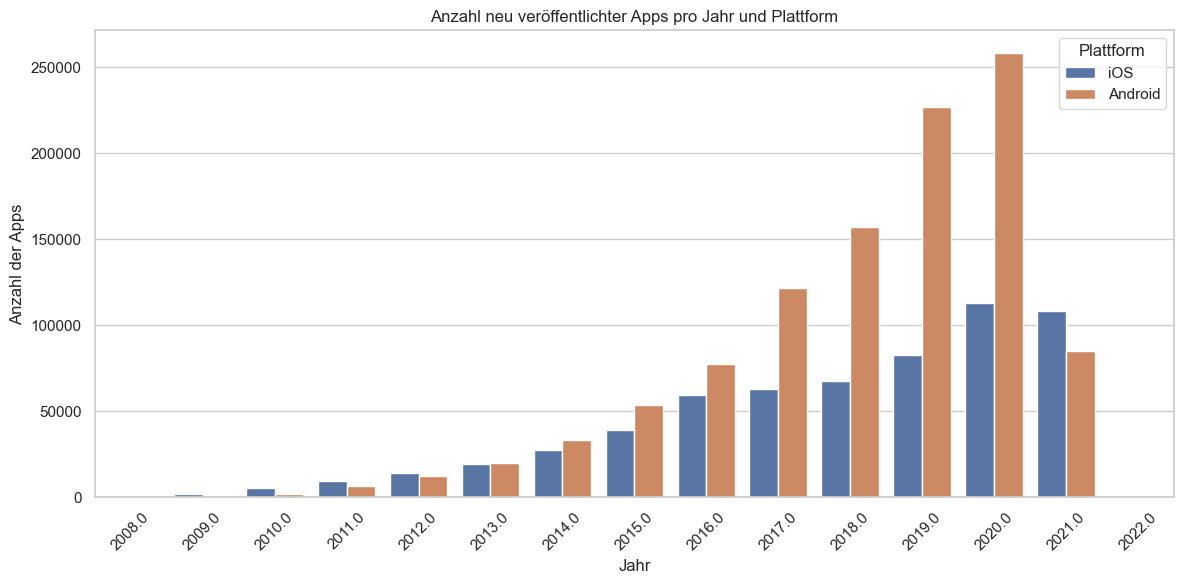

In [106]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_year_platform, x="year", y="count", hue="platform")
plt.title("Anzahl neu veröffentlichter Apps pro Jahr und Plattform")
plt.xlabel("Jahr")
plt.ylabel("Anzahl der Apps")
plt.xticks(rotation=45)
plt.legend(title="Plattform")
plt.tight_layout()
plt.show()

Da die Datensätze aus dem Jahr 2021/2022 stammen, werden nur Daten für die Jahre von 2008-2021 richtig dargestellt.

## Analyse: Nutzeraktivität nach Kategorie und Plattform (MapReduce)

Diese MapReduce-Auswertung summiert die Anzahl der Nutzerbewertungen (`num_reviews`) pro App-Kategorie und Plattform. Sie gibt Aufschluss über die aktivsten Kategorien im Markt und zeigt, wo Nutzer sich besonders engagieren.

In [105]:
# Aggregation Pipeline für Nutzeraktivität
pipeline_reviews = [
    {
        "$group": {
            "_id": { "category": "$category", "platform": "$platform" },
            "num_reviews": { "$sum": "$num_reviews" }
        }
    },
    {
        "$sort": { "num_reviews": -1 }
    }
]

# Aggregation durchführen
result_reviews = clean_coll.aggregate(pipeline_reviews)

# Konvertiere die Ergebnisse in ein Pandas DataFrame
df_reviews = pd.DataFrame([
    {
        'category': doc['_id']['category'],
        'platform': doc['_id']['platform'],
        'num_reviews': doc['num_reviews']
    }
    for doc in result_reviews
])

# Sortiere nach der Gesamtzahl der Bewertungen
df_reviews = df_reviews.sort_values(by="num_reviews", ascending=False)

,category,platform,num_reviews
0,Games,iOS,117852539.0
1,Shopping,iOS,34893514.0
2,Food & Drink,iOS,34432234.0
3,Finance,iOS,30586726.0
4,Travel,iOS,30434376.0


## Visualisierung: Gesamtzahl der Reviews je Kategorie und Plattform

Diese Darstellung zeigt, in welchen Kategorien Nutzer besonders aktiv sind, gemessen an der Gesamtanzahl der abgegebenen Reviews. Die Werte sind nach Plattform getrennt und zeigen Engagement-Muster im App-Markt.


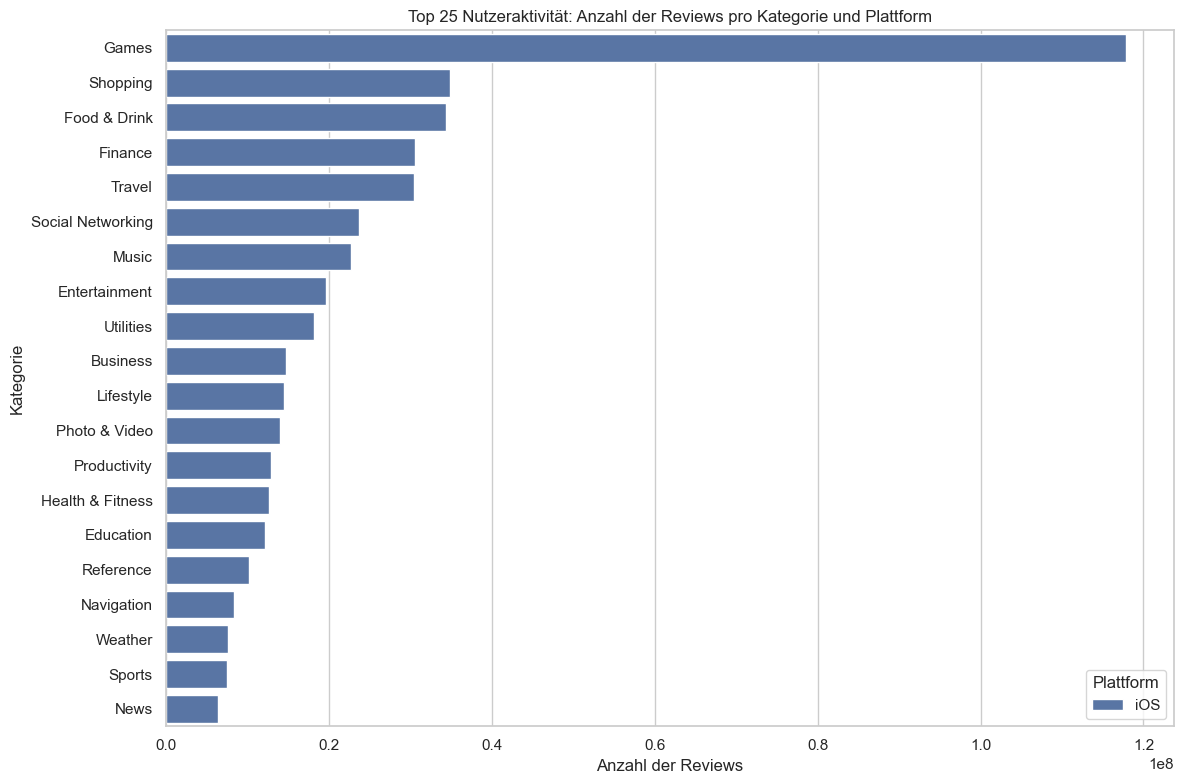

In [109]:
top_20_reviews = df_reviews.head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_reviews, x="num_reviews", y="category", hue="platform")
plt.title("Top 20 Nutzeraktivität: Anzahl der Reviews pro Kategorie und Plattform")
plt.xlabel("Anzahl der Reviews")
plt.ylabel("Kategorie")
plt.legend(title="Plattform")
plt.tight_layout()
plt.show()

#  6⃣  Fazit & Handlungsempfehlung
**Zusammenfassung:**
- Plattform-Vergleichstabelle
- Geschäftsempfehlungen je App-Typ:
  - iOS: Bessere Monetarisierung im Bildungs-/Lifestylebereich
  - Android: Größere Vielfalt, niedrigere Eintrittsbarrieren

## 📌 Zielgruppen & Nutzen
| Zielgruppe | Nutzen |
|------------|--------|
| Entwickler:innen | Wo zuerst launchen |
| Startups & Investoren | Geschäftsmodell-Entscheidungen |
| App-Marketing | Plattform-Performance nach Preismodell |
| Lehrende | Plattformpolitik & Verhalten verstehen |